In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz

In [2]:
# az.style.use("arviz-grayscale")
# from cycler import cycler
# default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
# plt.rc('axes', prop_cycle=default_cycler)
# plt.rc('figure', dpi=300)
np.random.seed(123)

In [3]:
cs_data = pd.read_csv('data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [4]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=10, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [5]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample(random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


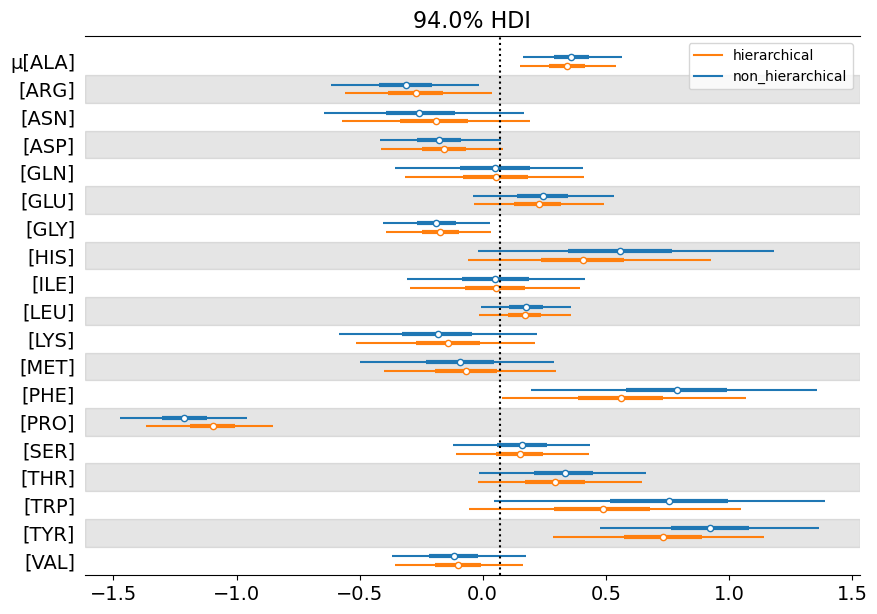

In [6]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['non_hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 7),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");
plt.savefig("../fig/csh_vs_csnh.png")

In [19]:
for name, model in zip(("cs_nh", "cs_h"), (cs_nh, cs_h)):
    graph = pm.model_to_graphviz(model)
    graph.graph_attr.update(size="2,2!")
    graph.graph_attr.update(dpi="300")
    graph.render(filename=name, format="png", cleanup=True)

In [8]:
N_samples = [30, 30, 30]
G_samples = [18, 18, 18]
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

In [9]:
with pm.Model() as model_h:
    # hypyerpriors
    μ = pm.Beta('μ', 1., 1.)
    ν = pm.HalfNormal('ν', 10)
    # prior
    θ = pm.Beta('θ', mu=μ, nu=ν, shape=len(N_samples))
    # likelihood
    y = pm.Bernoulli('y', p=θ[group_idx], observed=data)

    idata_h = pm.sample(random_seed=4591)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


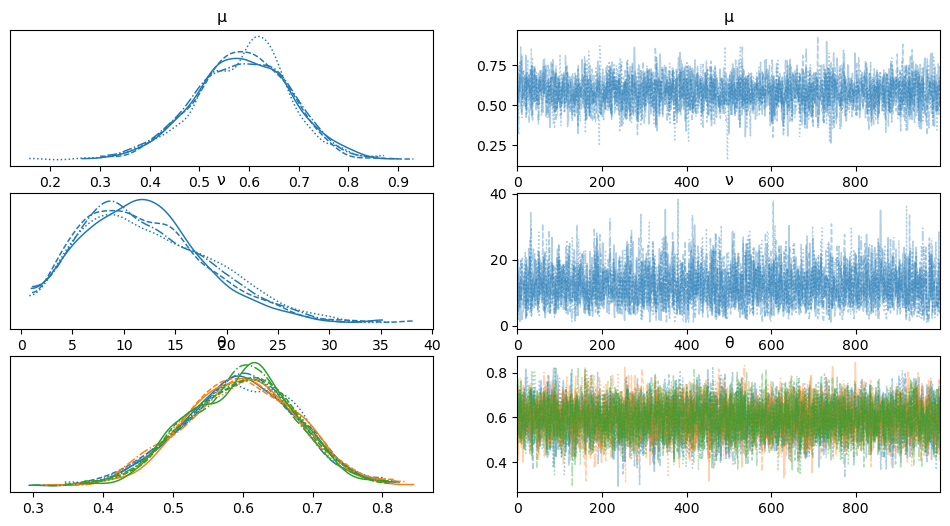

In [10]:
az.plot_trace(idata_h)
plt.savefig("../fig/idata_h_trace.png")

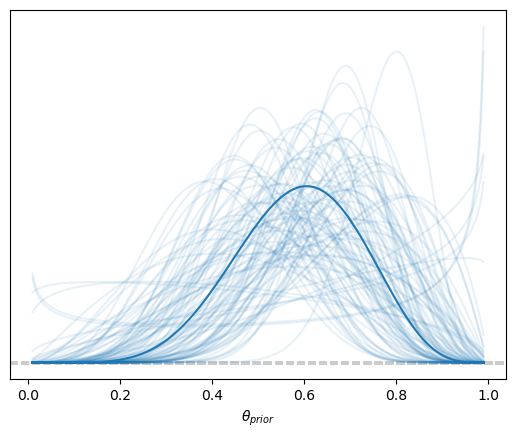

In [11]:

posterior = az.extract(idata_h, num_samples=100)
for sample in posterior[["μ", "ν"]].to_array().values.T:
    pz.Beta(mu=sample[0], nu=sample[1]).plot_pdf(legend=None, color="C0", alpha=0.1, support=(0.01, 0.99), moments="m")

pz.Beta(mu=posterior["μ"].mean().item(), nu=posterior["ν"].mean().item()).plot_pdf(legend=None, color="C0", moments="m")
plt.xlabel('$θ_{prior}$')
plt.savefig("../fig/idata_h_posterior.png")

In [12]:
for sample in posterior[["μ", "ν"]].to_array().values.T:
    print(sample)

[0.55439871 8.82816596]
[0.44875018 6.49909667]
[0.4739067  8.57521705]
[ 0.40247535 12.98095385]
[0.46909787 9.1589705 ]
[ 0.59429568 10.2575046 ]
[0.64306484 7.75216919]
[ 0.60047044 12.8160719 ]
[ 0.62439524 12.73723757]
[ 0.71724201 11.33862771]
[0.52000715 6.27001393]
[ 0.53815718 13.15535281]
[0.50933191 7.89170709]
[ 0.49866718 13.0469808 ]
[ 0.50002335 10.75553065]
[ 0.57527789 16.57479527]
[0.65613931 9.37575109]
[ 0.66114075 18.20276129]
[ 0.6203828  16.83636002]
[ 0.58559695 16.66914495]
[0.5397271  9.32425636]
[ 0.62826495 19.85575891]
[ 0.60446173 18.18267206]
[ 0.67303993 21.90204698]
[0.63962329 1.07451786]
[ 0.47783794 15.20451084]
[0.42764289 7.33434364]
[ 0.50462118 26.49486995]
[ 0.7230803  12.05359394]
[0.67785283 2.39101269]
[ 0.71600706 17.83461377]
[ 0.54004181 20.34141407]
[ 0.71108004 13.50476342]
[ 0.54791059 11.88877835]
[ 0.59563714 17.57992182]
[ 0.65652014 10.79545966]
[ 0.51429268 10.73348835]
[ 0.53996473 11.36057924]
[0.58264428 8.51102344]
[ 0.4668085 

In [13]:
football = pd.read_csv("data/football_players.csv", dtype={'position':'category'})
football

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


α = 1.67, β = 5.75


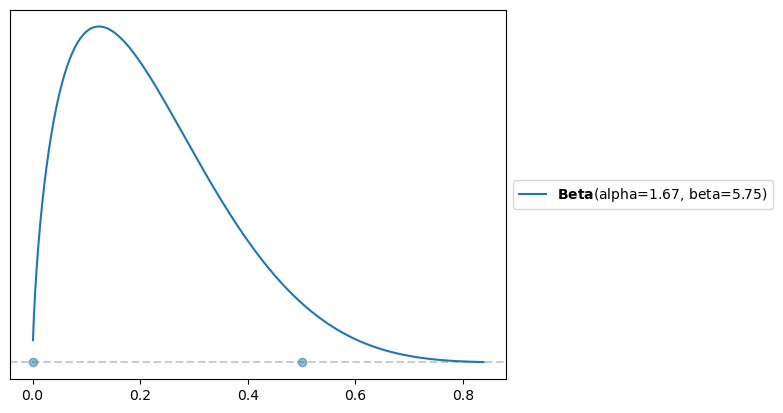

In [26]:
# Define the constraints
lower_bound = 0.0
upper_bound = 0.5
desired_mass = 0.95

dist = pz.Beta()
pz.maxent(dist, lower=lower_bound, upper=upper_bound, mass=desired_mass)
print(f"α = {dist.alpha:.2f}, β = {dist.beta:.2f}")


mu = 126.38, sigma = 47.98


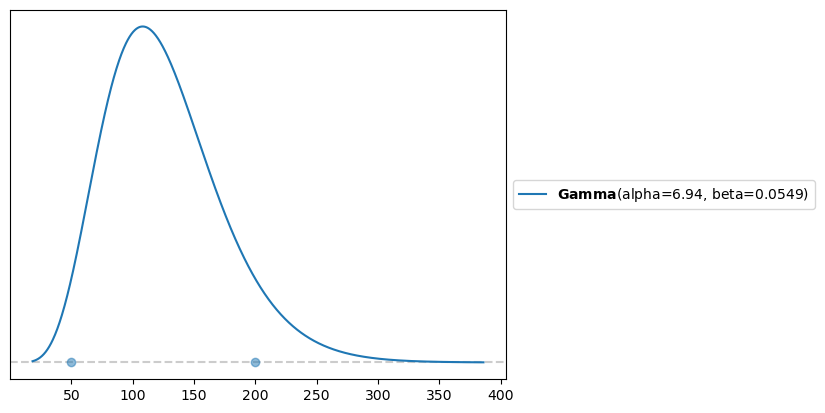

In [27]:
lower_bound = 50
upper_bound = 200
desired_mass = 0.90

dist = pz.Gamma()
pz.maxent(dist, lower=lower_bound, upper=upper_bound, mass=desired_mass)
print(f"mu = {dist.mu:.2f}, sigma = {dist.sigma:.2f}")

In [ ]:
def try_model_mu_p(nu_mu_pos=50, nu_sigma_pos=60, mu_alpha_pos=1.7, mu_beta_pos=5.8):
    # Hyper parameters
    μ_pos = pz.Beta(mu_alpha_pos, mu_beta_pos).rvs()
    ν_pos = pz.Gamma(mu=nu_mu_pos, sigma=nu_sigma_pos).rvs()

    # Parameters for positions
    μ_p = pz.Beta(mu=μ_pos, nu=ν_pos).rvs(100)

    return μ_p

In [61]:
total_players = football.shape[0]
percentage_missed_all_shots = (missed_all_shots_count / total_players) * 100
print(f"Number of players who missed all their shots: {missed_all_shots_count} out of {total_players} ({percentage_missed_all_shots:.2f}%)")

Number of players who missed all their shots: 545 out of 2682 (20.32%)


In [ ]:
pz.predictive_explorer(try_model_mu_p)

In [92]:
def try_model_theta(nu_mu_pos=50, nu_sigma_pos=60, nu_mu=150, nu_sigma=200, mu_alpha_pos=1.7, mu_beta_pos=5.8):
    # Hyper parameters
    μ_pos = pz.Beta(mu_alpha_pos, mu_beta_pos).rvs()
    ν_pos = pz.Gamma(mu=nu_mu_pos, sigma=nu_sigma_pos).rvs()

    # Parameters for positions
    μ_p = pz.Beta(mu=μ_pos, nu=ν_pos).rvs()
    
    ν_p = pz.Gamma(mu=nu_mu, sigma=nu_sigma).rvs()

    # Parameter for players
    θ = pz.Beta(mu=μ_p, nu=ν_p).rvs(100)

    return θ

In [93]:
pz.predictive_explorer(try_model_theta)

In [14]:
pos_idx = football.position.cat.codes.values
pos_codes = football.position.cat.categories
n_pos = pos_codes.size
n_players = football.index.size

In [15]:
coords = {"pos": pos_codes}
with pm.Model(coords=coords) as model_football:
    # Hyper parameters
    μ = pm.Beta('μ', 1.7, 5.8) 
    ν = pm.Gamma('ν', mu=125, sigma=50)

    
    # Parameters for positions
    μ_p = pm.Beta('μ_p',
                       mu=μ,
                       nu=ν,
                       dims = "pos")
    
    ν_p = pm.Gamma('ν_p', mu=125, sigma=50, dims="pos")
 
    # Parameter for players
    θ = pm.Beta('θ', 
                    mu=μ_p[pos_idx],
                    nu=ν_p[pos_idx])
    
    _ = pm.Binomial('gs', n=football.shots.values, p=θ, observed=football.goals.values)

    idata_football = pm.sample(draws=3000, target_accept=0.95, random_seed=4591)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, μ_p, ν_p, θ]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 513 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [94]:
graph = pm.model_to_graphviz(model_football)
graph.graph_attr.update(size="4,4!")
graph.graph_attr.update(dpi="300")
graph.render(filename="beta_binomial_hierarchical_subjects_dag", format="png", cleanup=True)

'beta_binomial_hierarchical_subjects_dag.png'

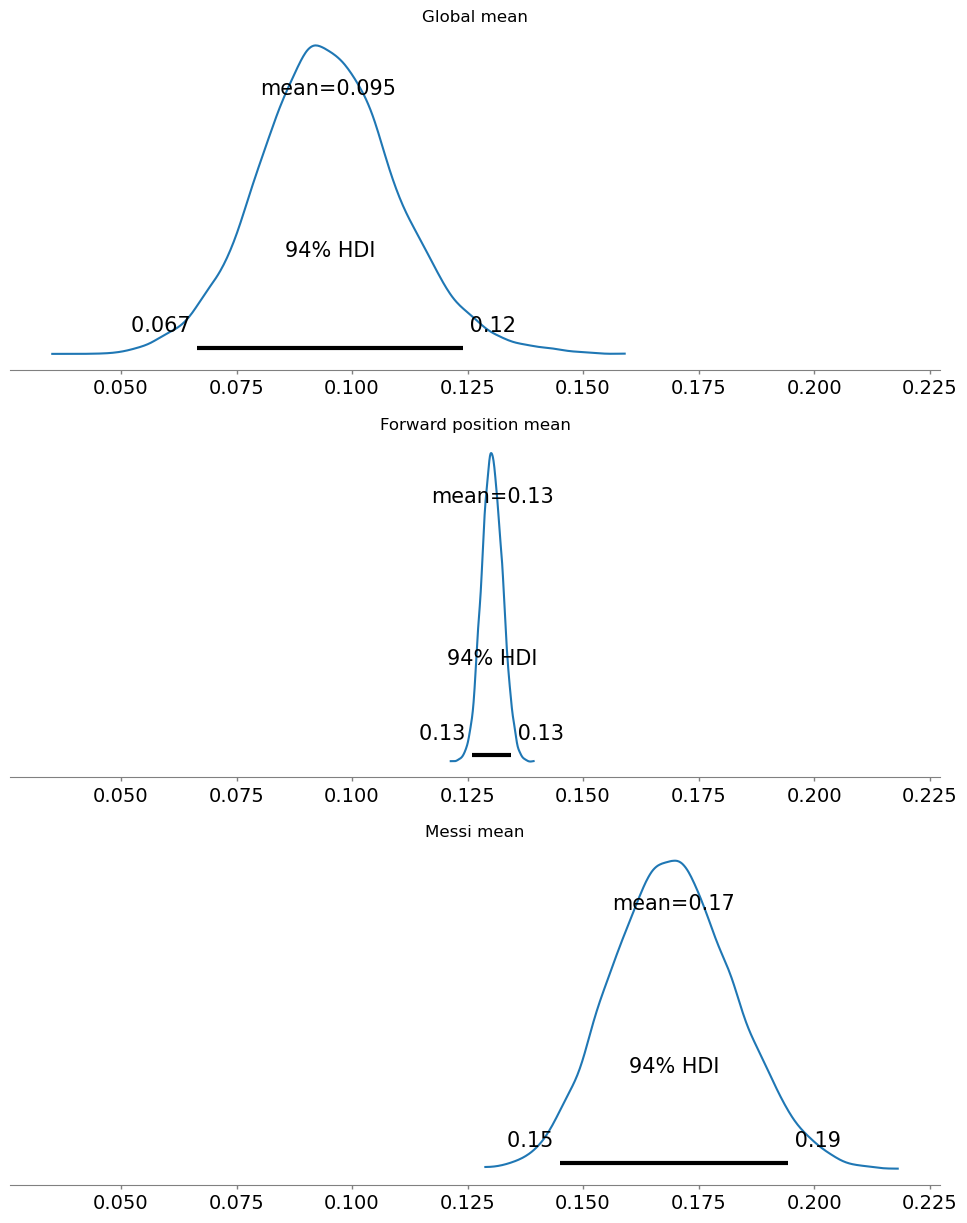

In [96]:
_, ax = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
az.plot_posterior(idata_football, var_names='μ', ax=ax[0])
ax[0].set_title(r"Global mean")
az.plot_posterior(idata_football.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")
az.plot_posterior(idata_football.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].set_title(r"Messi mean")
plt.savefig("../fig/beta_binomial_hierarchical_subjects_global_mus.png")

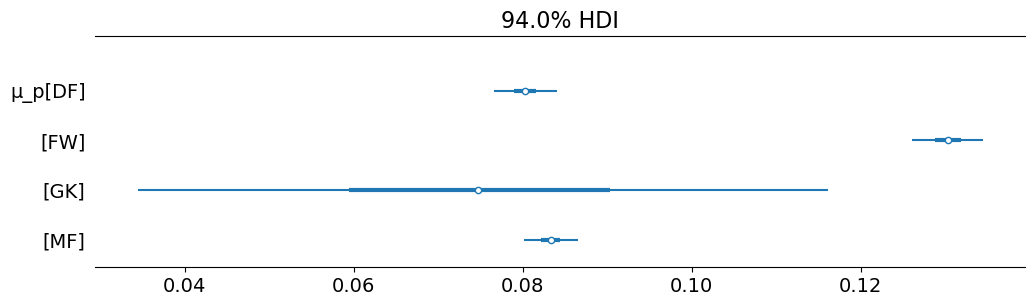

In [18]:
az.plot_forest(idata_football, var_names=['μ_p'], combined=True, figsize=(12, 3))
plt.savefig("../fig/beta_binomial_hierarchical_subjects_positions.png")

Text(0.5, 1.0, 'Global mean')

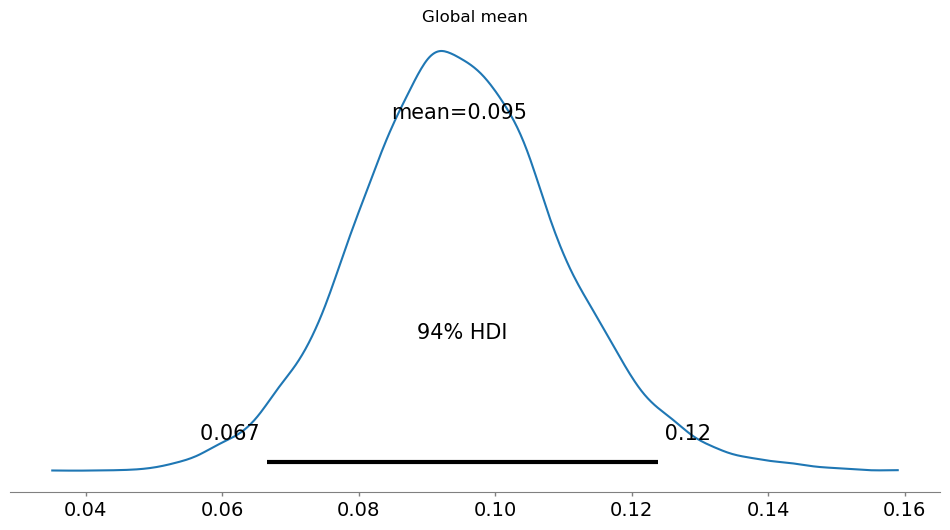

In [99]:
_, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=True)
az.plot_posterior(idata_football, var_names='μ', ax=ax)
ax.set_title(r"Global mean")


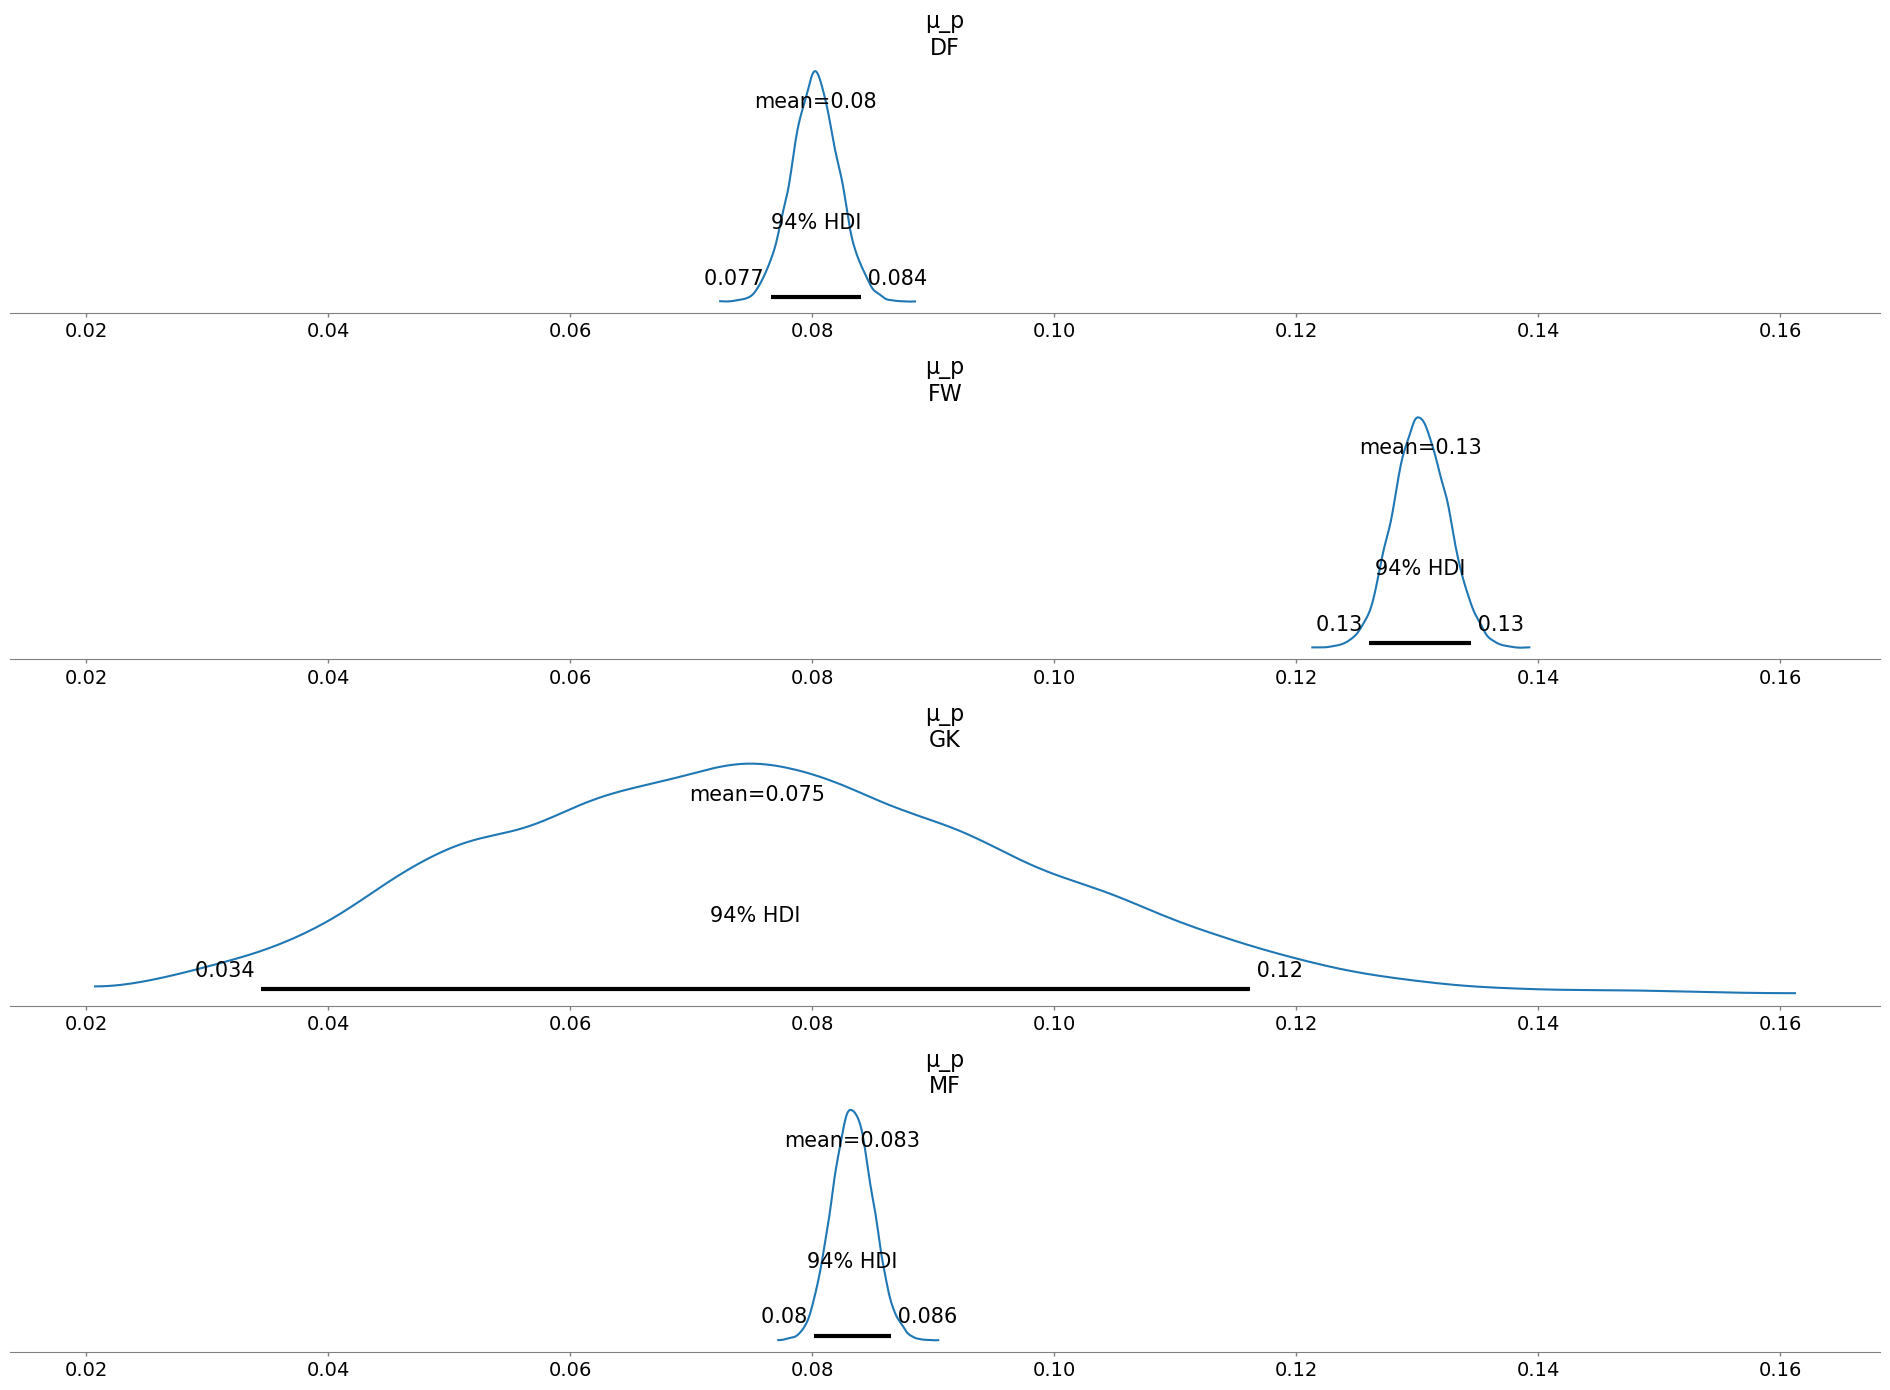

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(19, 14), sharex=True)
az.plot_posterior(idata_football, var_names='μ_p', grid=[4,1], ax=axes)
plt.tight_layout()


In [125]:
theta = idata_football.posterior['θ']
theta = theta.assign_coords(pos=('θ_dim_0', pos_codes[pos_idx]))
theta_forward = theta.sel(θ_dim_0=theta.pos == "FW")
theta_forward

<xarray.DataArray 'θ' (chain: 4, draw: 3000, θ_dim_0: 657)> Size: 63MB
array([[[0.16893041, 0.09544661, 0.12487631, ..., 0.10087878,
         0.11202515, 0.17340139],
        [0.06184462, 0.16369922, 0.10090886, ..., 0.2042365 ,
         0.10791317, 0.07977218],
        [0.17737385, 0.10300285, 0.15302837, ..., 0.10209704,
         0.12068324, 0.16766195],
        ...,
        [0.10434401, 0.12736135, 0.11988626, ..., 0.16347914,
         0.14061088, 0.09456035],
        [0.11279983, 0.13229645, 0.13321946, ..., 0.12893345,
         0.08966718, 0.15942553],
        [0.11303659, 0.10768819, 0.10591939, ..., 0.13194574,
         0.12291746, 0.08370636]],

       [[0.09092646, 0.14133233, 0.12709671, ..., 0.14376283,
         0.12220729, 0.10396165],
        [0.07560488, 0.13364901, 0.09630105, ..., 0.14998562,
         0.10901732, 0.10740583],
        [0.14097911, 0.1686827 , 0.12195385, ..., 0.16121754,
         0.11431138, 0.14592287],
...
        [0.06077527, 0.11132973, 0.10838459, ..., 0.11759696,
         0.09020212, 0.10644208],
        [0.11751606, 0.10638565, 0.17933581, ..., 0.18704715,
         0.11455039, 0.13681924],
        [0.13690761, 0.09819101, 0.10803074, ..., 0.16406664,
         0.13470406, 0.1396846 ]],

       [[0.08171869, 0.11685266, 0.11278765, ..., 0.13762495,
         0.15299677, 0.09127978],
        [0.09734842, 0.12606346, 0.10355065, ..., 0.19761958,
         0.10739672, 0.06666032],
        [0.1223448 , 0.13296112, 0.15841101, ..., 0.12631343,
         0.12432812, 0.17416661],
        ...,
        [0.08212656, 0.09955444, 0.13779089, ..., 0.16762397,
         0.11651558, 0.08861608],
        [0.09763437, 0.10399651, 0.10463634, ..., 0.16288314,
         0.14756345, 0.0971501 ],
        [0.10925047, 0.07911056, 0.10438016, ..., 0.13031345,
         0.14374972, 0.13334631]]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 12kB 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * θ_dim_0  (θ_dim_0) int32 3kB 0 4 12 17 23 27 ... 2666 2667 2668 2669 2670
    pos      (θ_dim_0) object 5kB 'FW' 'FW' 'FW' 'FW' ... 'FW' 'FW' 'FW' 'FW'

In [130]:
idata_football.posterior['μ_p'].pos

<xarray.DataArray 'pos' (pos: 4)> Size: 32B
array(['DF', 'FW', 'GK', 'MF'], dtype='<U2')
Coordinates:
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

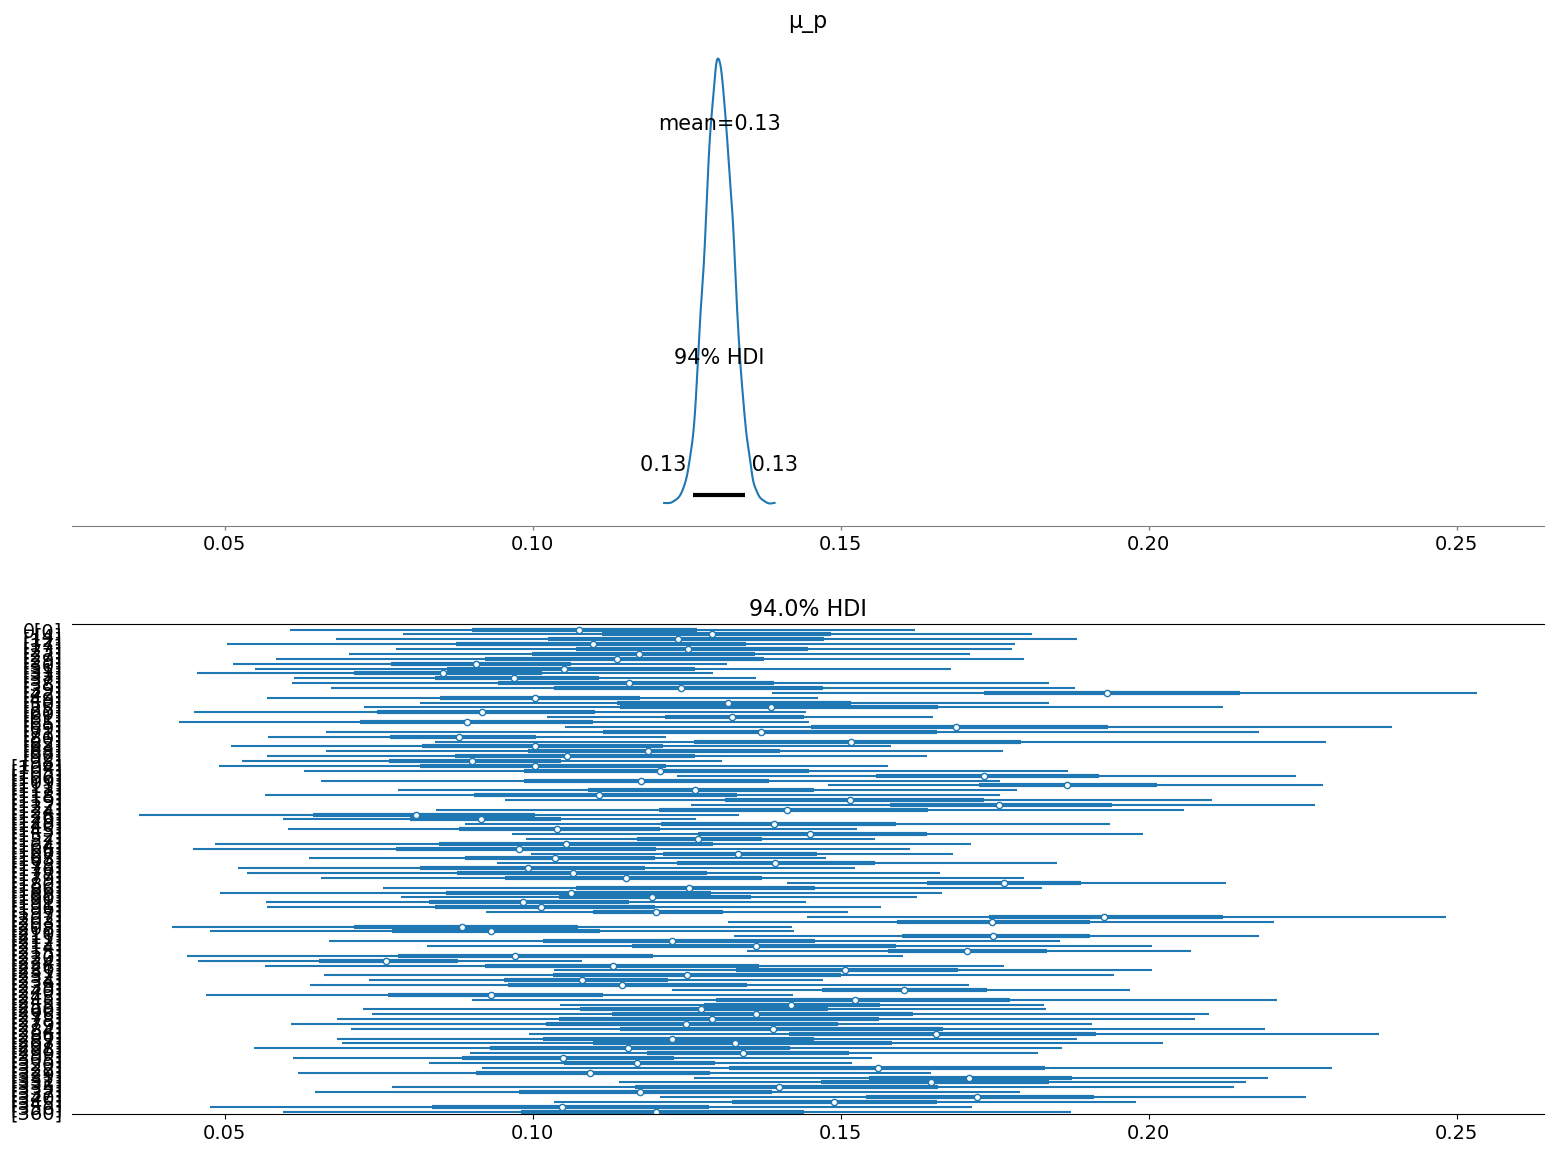

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(19, 14), sharex=True)
az.plot_posterior(idata_football, var_names='μ_p', coords={'pos':'FW'}, ax=axes[0])
az.plot_forest(theta_forward, ax=axes[1], 
               coords={'θ_dim_0': theta_forward.coords['θ_dim_0'][0:100]}, c
               ombined=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

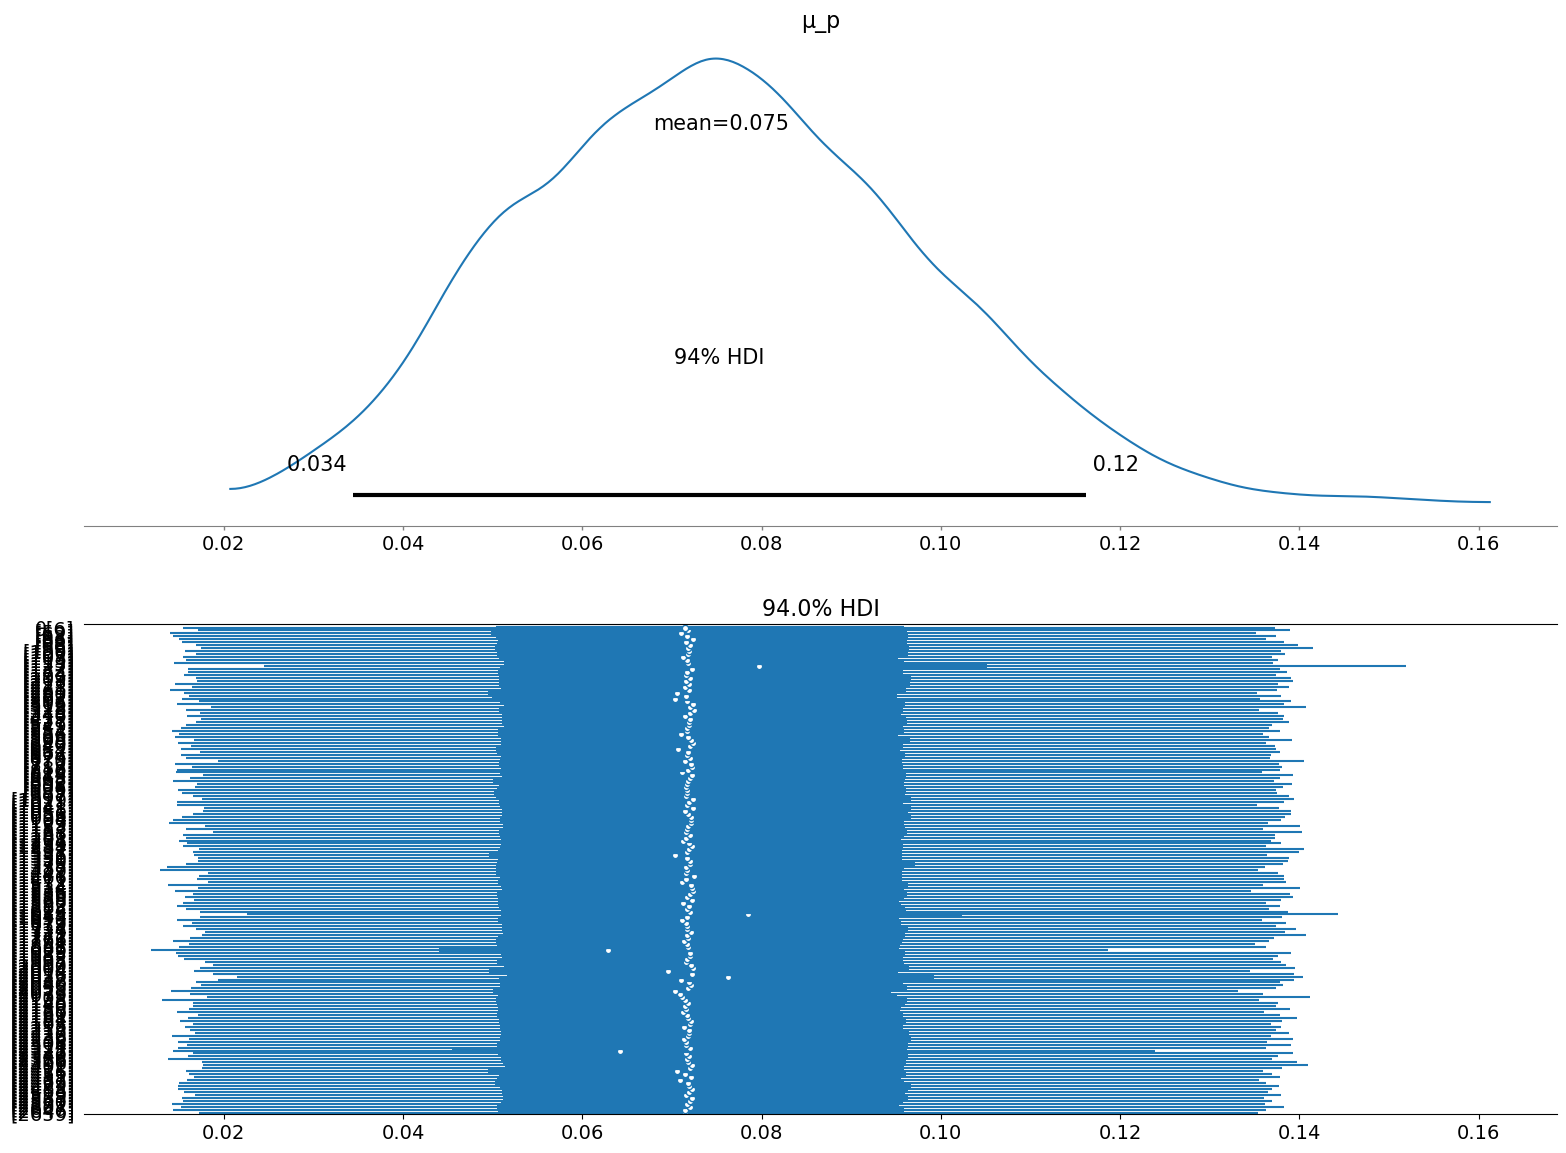

In [136]:
theta_goalie = theta.sel(θ_dim_0=theta.pos == "GK")

fig, axes = plt.subplots(2, 1, figsize=(19, 14), sharex=True)
az.plot_posterior(idata_football, var_names='μ_p', coords={'pos':'GK'}, ax=axes[0])
az.plot_forest(theta_goalie, ax=axes[1], 
               # coords={'θ_dim_0': theta_forward.coords['θ_dim_0'][0:100]}, 
               combined=True)


Text(0.5, 1.0, 'Standard deviation for forwards')

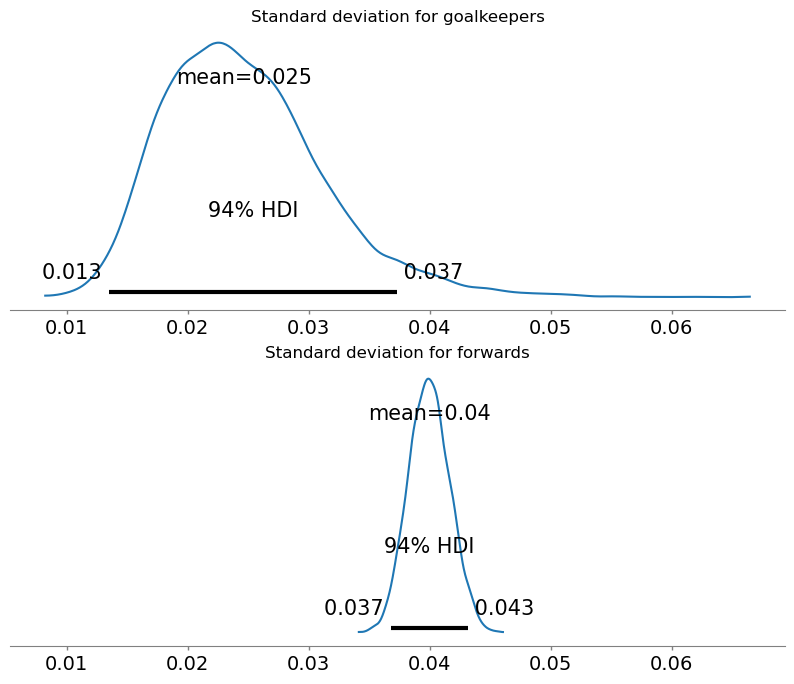

In [143]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
az.plot_posterior(theta_goalie.std(dim='θ_dim_0'), ax=axes[0])
axes[0].set_title("Standard deviation for goalkeepers")
az.plot_posterior(theta_forward.std(dim='θ_dim_0'), ax=axes[1])
axes[1].set_title("Standard deviation for forwards")

In [137]:
theta_goalie

<xarray.DataArray 'θ' (chain: 4, draw: 3000, θ_dim_0: 165)> Size: 16MB
array([[[0.09588072, 0.09853964, 0.09131988, ..., 0.07471145,
         0.0929699 , 0.08049038],
        [0.09222395, 0.08905196, 0.08125721, ..., 0.12095878,
         0.08441884, 0.09949847],
        [0.05867275, 0.10232806, 0.12736138, ..., 0.06651404,
         0.09512873, 0.08698263],
        ...,
        [0.11579676, 0.12536745, 0.15583197, ..., 0.10380333,
         0.11753905, 0.12735941],
        [0.10328144, 0.08756431, 0.08642842, ..., 0.13725371,
         0.10131126, 0.0899241 ],
        [0.0792917 , 0.10047597, 0.11865662, ..., 0.06862635,
         0.10643082, 0.11823076]],

       [[0.10922024, 0.05403655, 0.044163  , ..., 0.09930867,
         0.09832062, 0.13165082],
        [0.12492516, 0.06226824, 0.07167947, ..., 0.08843252,
         0.09535758, 0.11270813],
        [0.06076143, 0.13909236, 0.12092046, ..., 0.10581458,
         0.09264407, 0.08177576],
...
        [0.05177048, 0.06872577, 0.02114199, ..., 0.03172087,
         0.06519715, 0.0733177 ],
        [0.08240847, 0.10534482, 0.0371536 , ..., 0.03116717,
         0.13517151, 0.05819415],
        [0.1300463 , 0.05268892, 0.02997082, ..., 0.01971924,
         0.11654273, 0.08804844]],

       [[0.0429231 , 0.06464412, 0.01747865, ..., 0.07648699,
         0.0454476 , 0.04459868],
        [0.05534196, 0.04061088, 0.05396557, ..., 0.0640066 ,
         0.04008806, 0.04830044],
        [0.02220225, 0.04137136, 0.01612825, ..., 0.02602085,
         0.0438339 , 0.03803408],
        ...,
        [0.10175226, 0.12374063, 0.06542319, ..., 0.09949607,
         0.10702573, 0.17171931],
        [0.11772955, 0.08383657, 0.150616  , ..., 0.10219591,
         0.1140748 , 0.07178635],
        [0.1274786 , 0.13025852, 0.07306306, ..., 0.08660506,
         0.0866361 , 0.18244733]]])
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 12kB 0 1 2 3 4 5 6 ... 2994 2995 2996 2997 2998 2999
  * θ_dim_0  (θ_dim_0) int32 660B 6 59 62 63 66 93 ... 2570 2591 2607 2646 2659
    pos      (θ_dim_0) object 1kB 'GK' 'GK' 'GK' 'GK' ... 'GK' 'GK' 'GK' 'GK'